# Setup

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# SKlearn 
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
from sklearn import metrics
## LR
from sklearn.linear_model import LogisticRegression

###Decision Tree Claddifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

## Multi-drug use

In [3]:
incidents = pd.read_csv('../data/Aggregated/incidents.csv', )
incidents['Multiple Drugs'] = 0
incidents.loc[incidents['All Drugs'].str.contains(' | ', regex = False), 'Multiple Drugs'] = 1
incidents[incidents['Multiple Drugs'] == 1].shape

(8050, 17)

In [4]:
### fenytanl

incidents['Fentnyl'] = 0
incidents.loc[incidents['All Drugs'].str.contains('FENTANYL', regex = False), 'Fentnyl'] = 1
incidents[incidents['Fentnyl'] == 1].shape

(7255, 18)

In [5]:
incidents['Fentnyl'].value_counts()

0    13342
1     7255
Name: Fentnyl, dtype: int64

In [6]:
incidents.columns

Index(['Incident ID', 'Incident Date', 'Incident Time', 'Day',
       'Incident County Name', 'Incident State', 'Victim ID', 'Gender Desc',
       'Age Range', 'Race', 'Ethnicity Desc', 'Naloxone Administered',
       'Survive', 'Response Desc', 'All Drugs', 'Incident Date ym',
       'Multiple Drugs', 'Fentnyl'],
      dtype='object')

### Year, Month and Age Range

In [7]:
incidents["year"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)
incidents["month"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').month)

# Fix value typo
incidents["Age Range"] = incidents["Age Range"].apply(lambda x: "10 - 14" if x == "14-Oct" else x)

In [8]:
incidents.head(2)

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,Ethnicity Desc,Naloxone Administered,Survive,Response Desc,All Drugs,Incident Date ym,Multiple Drugs,Fentnyl,year,month
0,1,1/4/2018,0:42:00,Thursday,Delaware,Pennsylvania,1,Male,50 - 59,White,Not Hispanic,1,0,NO RESPONSE TO NALOXONE,COCAINE/CRACK | HEROIN,2018,1,0,2018,1
1,26,1/26/2018,9:14:00,Friday,Chester,Pennsylvania,5,Male,25 - 29,White,Not Hispanic,0,0,None,HEROIN,2018,0,0,2018,1


In [9]:
incidents['Age Range'].value_counts()

30 - 39    7653
25 - 29    4082
40 - 49    3434
20 - 24    2030
50 - 59    1871
60 - 69     634
0 - 9       530
15 - 19     276
70 - 79      70
80 - *       10
10 - 14       7
Name: Age Range, dtype: int64

In [10]:
def agerange_weekend(df):
    for i, row in df.iterrows():
        if row['Day'] == 'Friday' or row['Day'] == 'Saturday' or row['Day'] == 'Sunday':
            df.loc[i,'Weekend_OD'] = 1
        else:
            df.loc[i,'Weekend_OD'] = 0
        
        if row['month'] == 1 or row['month'] == 12 or row['month'] == 2:
            df.loc[i,'Season'] = 'Winter'
        elif row['month'] == 3 or row['month'] == 4 or row['month'] == 5:
            df.loc[i,'Season'] = 'Spring'
        elif row['month'] == 6 or row['month'] == 7 or row['month'] == 8:
            df.loc[i,'Season'] = 'Summer'
        elif row['month'] == 9 or row['month'] == 10 or row['month'] == 11:
            df.loc[i,'Season'] = 'Fall' 
            
        if row['Age Range'] == '0 - 9' or row['Age Range'] == '10 - 14' or row['Age Range'] == '15 - 19' or row['Age Range'] == '20 - 24' or row['Age Range'] == '30 - 39':
            df.loc[i,'Over 40'] = 0
        else:    
        
            df.loc[i,'Over 40'] = 1
            
    return(df)            
                
            
            
            

In [11]:
incidents2 = agerange_weekend(incidents.copy())

In [12]:
incidents2.head(2)

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,...,Response Desc,All Drugs,Incident Date ym,Multiple Drugs,Fentnyl,year,month,Weekend_OD,Season,Over 40
0,1,1/4/2018,0:42:00,Thursday,Delaware,Pennsylvania,1,Male,50 - 59,White,...,NO RESPONSE TO NALOXONE,COCAINE/CRACK | HEROIN,2018,1,0,2018,1,0.0,Winter,1.0
1,26,1/26/2018,9:14:00,Friday,Chester,Pennsylvania,5,Male,25 - 29,White,...,None,HEROIN,2018,0,0,2018,1,1.0,Winter,1.0


In [13]:
incidents2['Over 40'] = incidents2['Over 40'].astype(int)
incidents2['Weekend_OD'] = incidents2['Weekend_OD'].astype(int)

In [14]:
incidents2.dtypes

Incident ID               int64
Incident Date            object
Incident Time            object
Day                      object
Incident County Name     object
Incident State           object
Victim ID                 int64
Gender Desc              object
Age Range                object
Race                     object
Ethnicity Desc           object
Naloxone Administered     int64
Survive                   int64
Response Desc            object
All Drugs                object
Incident Date ym          int64
Multiple Drugs            int64
Fentnyl                   int64
year                      int64
month                     int64
Weekend_OD                int32
Season                   object
Over 40                   int32
dtype: object

In [17]:
#### Good

X = incidents2[['Over 40','Naloxone Administered','Fentnyl','Multiple Drugs']]
y = incidents2[['Survive']]

In [18]:
y['Survive'].value_counts()

1    15492
0     5105
Name: Survive, dtype: int64

In [19]:
class_weight_m = {0:15492,1:5105}

## Pipeline Definition

In [20]:
##pipeline  NOT GOOD

#label_features =['Season']
#label_transformer = OneHotEncoder(sparse = False, handle_unknown = 'ignore')



#preprocessor = ColumnTransformer(
    #transformers=[
        #('label', label_transformer, label_features)
        #])   


#model =  Pipeline(steps=[('preprocessor', preprocessor),
                     # ('randomforest', RandomForestClassifier(n_estimators=1000,
                      #                                        class_weight=class_weight_m))])

IndentationError: unexpected indent (<ipython-input-20-da7cf4eba02f>, line 15)

In [96]:
 
####Good

model =  Pipeline(steps=[
                      ('randomforest', RandomForestClassifier(n_estimators=1000,
                                                              class_weight=class_weight_m))])

In [91]:
#### Logistic regression

logisticRegr = Pipeline(steps=[
                            ('logisticregression', LogisticRegression(class_weight=class_weight_m))])

In [70]:
#### Decision Tree

dt =  Pipeline(steps=[('decisiontree',DecisionTreeClassifier(random_state = 42,class_weight=class_weight_m))])

In [92]:
# Split data with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

In [97]:
model.fit(X_train,y_train)


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
     steps=[('randomforest', RandomForestClassifier(bootstrap=True, class_weight={0: 15492, 1: 5105},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])

In [98]:
predictions_classweights = model.predict(X_test)
print("accuracy:",accuracy_score(y_test, predictions_classweights))

accuracy: 0.7821359223300971


In [93]:
###lr fit
logisticRegr.fit(X_train,y_train)

C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight={0: 15492, 1: 5105}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [94]:
###Lr accuracy from training
LR_predictions_classweights = logisticRegr.predict(X_test)
print("accuracy:",accuracy_score(y_test, LR_predictions_classweights))


accuracy: 0.7821359223300971


In [89]:
dt.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('decisiontree', DecisionTreeClassifier(class_weight={0: 15492, 1: 5105}, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])

In [95]:
###Lr accuracy from training
dt_predictions_classweights = dt.predict(X_test)
print("accuracy:",accuracy_score(y_test, dt_predictions_classweights))


accuracy: 0.7821359223300971


In [25]:
from sklearn.model_selection import StratifiedKFold
import numpy
kf = StratifiedKFold(n_splits=5,random_state=0, shuffle=True)

 
acc_score = []
pred = []
y_test_all = []
predprob = []
 
for train_index , test_index in kf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    model.fit(X_train,y_train)
    print(model.score(X_test, y_test))
    num = model.score(X_test, y_test)
    num = num.astype(float)
    acc_score.append(num)
    
    
    predictions_classweights = model.predict(X_test)
    proba = model.predict_proba(X_test)
    predprob.append(proba)                           
    
    #predict_class = np.argmax(test_predictions, axis=1)
    #predict_class = predict_class.tolist()
    
    pred.append(predictions_classweights)
    y_test_all.append(y_test)


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.7762135922330097


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.7776699029126214


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.7836853605243991


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.7882981306142267


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.7747025977178927


In [44]:
###LR

from sklearn.model_selection import StratifiedKFold
import numpy
kf = StratifiedKFold(n_splits=5,random_state=0, shuffle=True)

 
acc_score = []
pred = []
y_test_all = []
predprob = []
 
for train_index , test_index in kf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    logisticRegr.fit(X_train,y_train)
    print(logisticRegr.score(X_test, y_test))
    num = logisticRegr.score(X_test, y_test)
    num = num.astype(float)
    acc_score.append(num)
    
    
    predictions_classweights = logisticRegr.predict(X_test)
    proba = logisticRegr.predict_proba(X_test)
    predprob.append(proba)                           
    
    #predict_class = np.argmax(test_predictions, axis=1)
    #predict_class = predict_class.tolist()
    
    pred.append(predictions_classweights)
    y_test_all.append(y_test)


0.7762135922330097
0.7776699029126214
0.7836853605243991
0.7882981306142267
0.7747025977178927


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

In [45]:
pred_master = np.hstack(([pred[0],pred[1],pred[2],pred[3],pred[4]]))
y_test_master = pd.concat(y_test_all)

In [46]:
pr0 = pd.DataFrame(predprob[0],columns=['zero','one'])
pr1 = pd.DataFrame(predprob[1],columns=['zero','one'])
pr2 = pd.DataFrame(predprob[2],columns=['zero','one'])
pr3 = pd.DataFrame(predprob[3],columns=['zero','one'])
pr4 = pd.DataFrame(predprob[4],columns=['zero','one'])

In [62]:
prdf1 = pd.concat([pr0,pr1,pr2,pr3,pr4])
prdf1 = prdf1[['one']]
prdf2 =prdf1.copy()

In [63]:
prdf2['one'] = np.select([prdf2['one']>.62],  ### setting threshold
                        [1],
                        default=0)

In [64]:
confusion = confusion_matrix(y_test_master,prdf2)

In [65]:
print(confusion)

[[ 3801  1304]
 [ 4700 10792]]


In [66]:
target_names = ['Died', 'Survived']
print(classification_report(y_test_master, prdf2, target_names=target_names))

              precision    recall  f1-score   support

        Died       0.45      0.74      0.56      5105
    Survived       0.89      0.70      0.78     15492

   micro avg       0.71      0.71      0.71     20597
   macro avg       0.67      0.72      0.67     20597
weighted avg       0.78      0.71      0.73     20597



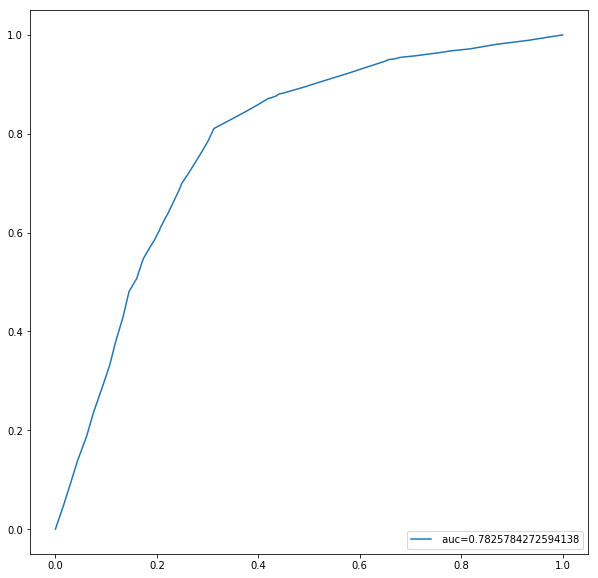

In [34]:
fpr, tpr, _ = metrics.roc_curve(y_test_master,prdf1)
auc = metrics.roc_auc_score(y_test_master,prdf1)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,label=" auc="+str(auc))
plt.legend(loc=4)
plt.show()